In [1]:
!curl -O https://maxhalford.github.io/files/datasets/creditcardfraud.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.9M  100 65.9M    0     0  22.0M      0  0:00:02  0:00:02 --:--:-- 22.0M


In [2]:
! unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
import pandas as pd
from sklearn import model_selection
from scipy.misc import derivative
import numpy as np
import lightgbm
from sklearn import metrics

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
df = pd.read_csv('creditcard.csv')
X = df.drop(columns='Class')
y = df['Class']

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y,
    random_state=42
)

X_fit, X_val, y_fit, y_val = model_selection.train_test_split(
    X_train, y_train,
    random_state=42
)

X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
83225,59741.0,-1.648591,1.228130,1.370169,-1.735542,-0.029455,-0.484129,0.918645,-0.438750,0.982144,...,0.384201,-0.218076,-0.203458,-0.213015,0.011372,-0.304481,0.632063,-0.262968,-0.099863,38.42
52800,45648.0,-0.234775,-0.493269,1.236728,-2.338793,-1.176733,0.885733,-1.960981,-2.363412,-2.694774,...,0.364679,-1.495358,-0.083066,0.074612,-0.347329,0.541900,-0.433294,0.089293,0.212029,61.20
21293,31579.0,1.134626,-0.774460,-0.163390,-0.533358,-0.604555,-0.244482,-0.212682,0.040782,-1.136627,...,-0.396476,-0.684454,-1.855269,0.171997,-0.387783,-0.062985,0.245118,-0.061178,0.012180,110.95
133600,80455.0,0.069514,1.017753,1.033117,1.384376,0.223233,-0.310845,0.597287,-0.127658,-0.701533,...,0.148760,0.097023,0.369957,-0.219266,-0.124941,-0.049749,-0.112946,0.114440,0.066101,10.00
38225,39302.0,-0.199441,0.610092,-0.114437,0.256565,2.290752,4.008475,-0.123530,1.038374,-0.075846,...,0.292972,-0.019733,0.165463,-0.080978,1.020656,-0.300730,-0.269595,0.481769,0.254114,22.00


In [5]:
y.value_counts()

,count
Class,
0,284315
1,492


In [6]:
lgbtrain = lightgbm.Dataset(X_fit, y_fit)
lgbeval = lightgbm.Dataset(X_val, y_val, reference=lgbtrain)

model = lightgbm.train(
    params={
        'learning_rate': 0.01,
        'objective': 'binary'
    },
    train_set=lgbtrain,
    num_boost_round=100,
    valid_sets=(lgbtrain, lgbeval),
    valid_names=('fit', 'val'),
    callbacks=[
        lightgbm.early_stopping(stopping_rounds=20),
    ],
)

y_proba = model.predict(X_test)
y_pred = y_proba > 0.5

[LightGBM] [Info] Number of positive: 283, number of negative: 159920
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 160203, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001767 -> initscore=-6.336982
[LightGBM] [Info] Start training from score -6.336982
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	fit's binary_logloss: 0.0018981	val's binary_logloss: 0.0035569


In [7]:
print()
print(f"Test's ROC AUC: {metrics.roc_auc_score(y_test, y_proba):.5f}")
print(f"Test's logloss: {metrics.log_loss(y_test, y_proba):.5f}")
print(f"Test's average precision: {metrics.average_precision_score(y_test, y_proba):.5f}")
print(metrics.classification_report(y_test, y_pred))


Test's ROC AUC: 0.96174
Test's logloss: 0.00326
Test's average precision: 0.85113
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71089
           1       0.94      0.64      0.76       113

    accuracy                           1.00     71202
   macro avg       0.97      0.82      0.88     71202
weighted avg       1.00      1.00      1.00     71202



Focal Loss

In [8]:
def focal_loss_lgb(y_pred, dtrain, alpha, gamma):
	a,g = alpha, gamma
	y_true = dtrain.label
	def fl(x,t):
		p = 1/(1+np.exp(-x))
		return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
	partial_fl = lambda x: fl(x, y_true)
	grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
	hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
	return grad, hess

In [9]:
def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma):
	a,g = alpha, gamma
	y_true = dtrain.label
	p = 1/(1+np.exp(-y_pred))
	loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
	return 'focal_loss', np.mean(loss), False

In [10]:
focal_loss = lambda x,y: focal_loss_lgb(x, y, 0.25, 1.)
eval_error = lambda x,y: focal_loss_lgb_eval_error(x, y, 0.25, 1.)
lgbtrain = lightgbm.Dataset(X_fit, y_fit, free_raw_data=True)
lgbeval = lightgbm.Dataset(X_val, y_val)
params  = {'learning_rate':0.1, 'num_boost_round':100, "objective": focal_loss}
model = lightgbm.train(params, lgbtrain, valid_sets=[lgbeval], feval=eval_error, callbacks=[lightgbm.early_stopping(stopping_rounds=20),])

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 160203, number of used features: 30
[LightGBM] [Info] Using self-defined objective function


<ipython-input-8-9de69f991ac0>:8: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
<ipython-input-8-9de69f991ac0>:9: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's focal_loss: 0.000448057


In [11]:
y_proba = model.predict(X_test)
y_pred = y_proba > 0.5

In [12]:
print()
print(f"Test's ROC AUC: {metrics.roc_auc_score(y_test, y_proba):.5f}")
print(f"Test's logloss: {metrics.log_loss(y_test, y_proba):.5f}")
print(f"Test's average precision: {metrics.average_precision_score(y_test, y_proba):.5f}")
print(metrics.classification_report(y_test, y_pred))


Test's ROC AUC: 0.97893
Test's logloss: 0.01433
Test's average precision: 0.86107
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71089
           1       0.96      0.73      0.83       113

    accuracy                           1.00     71202
   macro avg       0.98      0.86      0.91     71202
weighted avg       1.00      1.00      1.00     71202



In [13]:
lightgbm.__version__

'4.4.0'

Usando API do Sklearn

In [14]:
def focal_loss_lgb_sk(y_true, y_pred, alpha, gamma):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    """
    global last_grad
    global last_hess
    a,g = alpha, gamma
    def fl(x,t):
        p = 1/(1+np.exp(-x))
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return grad, hess

In [15]:
def focal_loss_lgb_eval_error_sk(y_true, y_pred, alpha, gamma):
    """
    Adapation of the Focal Loss for lightgbm to be used as evaluation loss

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    """
    a,g = alpha, gamma
    p = 1/(1+np.exp(-y_pred))
    loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
    return 'focal_loss', np.mean(loss), False

In [16]:
focal_loss = lambda x,y: focal_loss_lgb_sk(x, y, 0.25, 2.)
eval_error = lambda x,y: focal_loss_lgb_eval_error_sk(x, y, 0.25, 2.)
model = lightgbm.LGBMClassifier(objective=focal_loss, learning_rate=0.1, num_boost_round=100, early_stopping_rounds=20, verbose = 0)
model.fit(
    X_fit,
    y_fit,
    eval_set=[(X_val, y_val)],
    eval_metric=eval_error)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Using self-defined objective function


<ipython-input-14-1652dbc51a81>:20: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
<ipython-input-14-1652dbc51a81>:21: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)


LGBMClassifier(early_stopping_rounds=20, num_boost_round=100,
               objective=<function <lambda> at 0x7d3d05529360>, verbose=0)

In [17]:
y_proba = model.predict_proba(X_test)
y_pred = y_proba > 0.5

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:1346: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(


In [18]:
print()
print(f"Test's ROC AUC: {metrics.roc_auc_score(y_test, y_proba):.5f}")
print(f"Test's logloss: {metrics.log_loss(y_test, y_proba):.5f}")
print(f"Test's average precision: {metrics.average_precision_score(y_test, y_proba):.5f}")
print(metrics.classification_report(y_test, y_pred))


Test's ROC AUC: 0.97736
Test's logloss: 0.01397
Test's average precision: 0.86956
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71089
           1       0.95      0.70      0.81       113

    accuracy                           1.00     71202
   macro avg       0.98      0.85      0.90     71202
weighted avg       1.00      1.00      1.00     71202



Regression

In [19]:
from sklearn.datasets import load_diabetes

In [20]:
dataset = load_diabetes()

In [21]:
dataset.keys()

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

In [96]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    dataset['data'], dataset['target'],
    random_state=42
)

X_fit, X_val, y_fit, y_val = model_selection.train_test_split(
    X_train, y_train,
    random_state=42
)

In [146]:
last_grad = None
last_hess = None

def objective_ls(y_true, y_pred, alpha = 0.98, lamb = 2):
  global last_grad
  global last_hess
  grad = (y_pred - y_true)
  hess = np.ones(len(y_true))

  if last_grad is not None:
    for n in range(len(grad)):
      last_grad[n] = last_grad[n] * alpha + grad[n] * (1 - alpha)
      grad[n] = grad[n] + last_grad[n] * lamb

    for n in range(len(grad)):
      last_hess[n] = last_hess[n] * alpha + hess[n] * (1 - alpha)
      hess[n] = hess[n] + last_hess[n] * lamb
    else:
      last_grad = grad
      last_hess = hess
  return grad, hess

def absolute_error_obj(alpha):
    def absolute_error(labels, predt, alpha_grok = 0.98, lamb = 2.0):
        global last_grad
        global last_hess
        x = predt - labels
        grad = np.sign(x)
        grad[np.abs(x) < alpha] = 2/alpha*x[np.abs(x) < alpha]
        hess = np.zeros_like(labels)
        hess[np.abs(x) < alpha] = 2/alpha
        if last_grad is not None:
          for n in range(len(grad)):
            last_grad[n] = last_grad[n] * alpha_grok + grad[n] * (1 - alpha_grok)
            grad[n] = grad[n] + last_grad[n] * lamb

          for n in range(len(grad)):
            last_hess[n] = last_hess[n] * alpha_grok + hess[n] * (1 - alpha_grok)
            hess[n] = hess[n] + last_hess[n] * lamb
          else:
            last_grad = grad
            last_hess = hess
        return grad, hess
    return absolute_error

In [147]:
from sklearn.metrics import mean_absolute_error as mae
from lightgbm import LGBMRegressor

# Create an instance of the LightGBM Regressor with the RMSE metric.
model = LGBMRegressor(objective=absolute_error_obj(1000), num_iterations=100, early_stopping_rounds=20)

# Train the model using the training data.
model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
    eval_metric='mae')

[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 331, number of used features: 10
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMRegressor(early_stopping_rounds=20, num_iterations=100,
              objective=<function absolute_error_obj.<locals>.absolute_error at 0x7d3c61e60c10>)

In [148]:
# Make predictions on the training and validation data.
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

In [149]:
print("Training MAE: ", mae(y_train, y_pred_train))
print("Validation MAE: ", mae(y_val, y_pred_val))
print("Test MAE: ", mae(y_test, y_pred_test))

Training MAE:  17.427838170721184
Validation MAE:  17.26335546741846
Test MAE:  44.062678849463346


Training MAE:  17.427838170721184
Validation MAE:  17.26335546741846
Test MAE:  44.062678849463346

Grokfast

In [27]:
from collections import deque
from typing import Dict, Optional, Literal
import torch
import torch.nn as nn


def gradfilter_ma(
    m: nn.Module,
    grads: Optional[Dict[str, deque]] = None,
    window_size: int = 100,
    lamb: float = 5.0,
    filter_type: Literal['mean', 'sum'] = 'mean',
    warmup: bool = True,
    trigger: bool = False, # For ablation study.
) -> Dict[str, deque]:
    if grads is None:
        grads = {n: deque(maxlen=window_size) for n, p in m.named_parameters() if p.requires_grad and p.grad is not None}

    for n, p in m.named_parameters():
        if p.requires_grad and p.grad is not None:
            grads[n].append(p.grad.data.detach()) # .cpu())

            # Modify the gradients.
            if not warmup or len(grads[n]) == window_size and not trigger:
                if filter_type == "mean":
                    avg = sum(grads[n]) / len(grads[n])
                elif filter_type == "sum":
                    avg = sum(grads[n])
                else:
                    raise ValueError(f"Unrecognized filter_type {filter_type}")
                p.grad.data = p.grad.data + avg * lamb

    return grads


def gradfilter_ema(
    m: nn.Module,
    grads: Optional[Dict[str, torch.Tensor]] = None,
    alpha: float = 0.98,
    lamb: float = 2.0,
) -> Dict[str, torch.Tensor]:
    if grads is None:
        grads = {n: p.grad.data.detach() for n, p in m.named_parameters() if p.requires_grad and p.grad is not None}

    for n, p in m.named_parameters():
        if p.requires_grad and p.grad is not None:
            grads[n] = grads[n] * alpha + p.grad.data.detach() * (1 - alpha)
            p.grad.data = p.grad.data + grads[n] * lamb

    return grads

Pytorch Model

In [28]:
import torch.nn as nn

sizes = [X_train[0].shape[0], X_train[0].shape[0]*4, X_train[0].shape[0]*2, X_train[0].shape[0], 1]

# Define the model
model = nn.Sequential(
    nn.Linear(sizes[0], sizes[1]),
    nn.ReLU(),
    nn.Linear(sizes[1], sizes[2]),
    nn.ReLU(),
    nn.Linear(sizes[2], sizes[3]),
    nn.ReLU(),
    nn.Linear(sizes[3], sizes[4])
)

In [29]:
import torch.optim as optim

# loss function and optimizer
loss_fn = nn.L1Loss()  # mean absolute error
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

In [30]:
import numpy as np
import torch
import tqdm
from sklearn.model_selection import train_test_split
import copy

# train-test split of the dataset
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# training parameters
n_epochs = 1000   # number of epochs to run
batch_size = 64  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mae = np.inf   # init to infinity
best_weights = None
history = []
grads = None

# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            grads = gradfilter_ema(model, grads=grads)
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mae=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mae = loss_fn(y_pred, y_test)
    mae = float(mae)
    history.append(mae)
    if mae < best_mae:
        best_mae = mae
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

MAE: 51.48


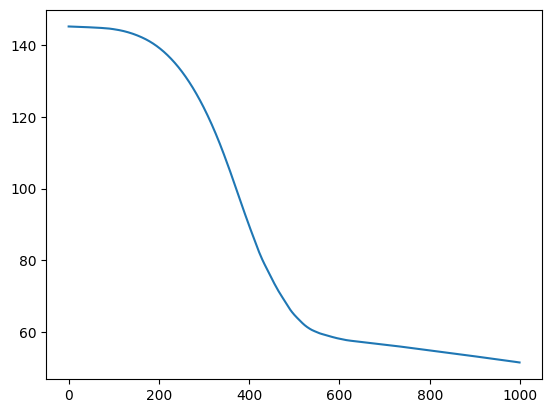

In [31]:
import matplotlib.pyplot as plt
print("MAE: %.2f" % best_mae)
plt.plot(history)
plt.show()